# TEAM 44 - kdd cyberattack (K09)

This is the second part of the first lab assignment of the course "Neural Networks and Intelligent Systems" at the National Technical University of Athens.

**Team 44** consists of **George Kyriakopoulos** (03118153) and **Serafeim Tzelepis** (03118849).

## Packages and imports

In [12]:
%pip install pip --upgrade
%pip install scikit-learn --upgrade
%pip install numpy --upgrade
%pip install matplotlib --upgrade
%pip install imbalanced-learn --upgrade
%pip install pandas --upgrade
%pip install tabulate --upgrade
%pip install seaborn --upgrade
%pip install optuna --upgrade

In [2]:
import time
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Introduction and Overview

For this part we will use a Kaggle dataset, [kdd cyberattack](https://www.kaggle.com/datasets/slashtea/kdd-cyberattack).

This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

The dataset contains a total of [22 training attack types](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types) (excluding the normal label), that fall into four main categories, DOS, R2L, U2R and probing, with an additional 14 types in the test data only. The dataset has 42 variables in total.

In [3]:
# get kddcup.data_10_percent.csv file
!wget -q http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz -P resources
!gunzip -f -q resources/kddcup.data_10_percent.gz
!mv resources/kddcup.data_10_percent resources/kddcup.data_10_percent.csv

# read data from kddcup.data_10_percent.csv file
df = pd.read_csv('resources/kddcup.data_10_percent.csv', header=None)

# print basic info about dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       494021 non-null  int64  
 1   1       494021 non-null  object 
 2   2       494021 non-null  object 
 3   3       494021 non-null  object 
 4   4       494021 non-null  int64  
 5   5       494021 non-null  int64  
 6   6       494021 non-null  int64  
 7   7       494021 non-null  int64  
 8   8       494021 non-null  int64  
 9   9       494021 non-null  int64  
 10  10      494021 non-null  int64  
 11  11      494021 non-null  int64  
 12  12      494021 non-null  int64  
 13  13      494021 non-null  int64  
 14  14      494021 non-null  int64  
 15  15      494021 non-null  int64  
 16  16      494021 non-null  int64  
 17  17      494021 non-null  int64  
 18  18      494021 non-null  int64  
 19  19      494021 non-null  int64  
 20  20      494021 non-null  int64  
 21  21      49

There was no needed transformation of the data, since it was already in a usable form.

There are 494021 samples and 41 features in the dataset. The types of the features are as follows:

* duration: continuous
* protocol_type: symbolic
* service: symbolic
* flag: symbolic
* src_bytes: continuous
* dst_bytes: continuous
* land: symbolic
* wrong_fragment: continuous
* urgent: continuous
* hot: continuous
* num_failed_logins: continuous
* logged_in: symbolic
* num_compromised: continuous
* root_shell: continuous
* su_attempted: continuous
* num_root: continuous
* num_file_creations: continuous
* num_shells: continuous
* num_access_files: continuous
* num_outbound_cmds: continuous
* is_host_login: symbolic
* is_guest_login: symbolic
* count: continuous
* srv_count: continuous
* serror_rate: continuous
* srv_serror_rate: continuous
* rerror_rate: continuous
* srv_rerror_rate: continuous
* same_srv_rate: continuous
* diff_srv_rate: continuous
* srv_diff_host_rate: continuous
* dst_host_count: continuous
* dst_host_srv_count: continuous
* dst_host_same_srv_rate: continuous
* dst_host_diff_srv_rate: continuous
* dst_host_same_src_port_rate: continuous
* dst_host_srv_diff_host_rate: continuous
* dst_host_serror_rate: continuous
* dst_host_srv_serror_rate: continuous
* dst_host_rerror_rate: continuous
* dst_host_srv_rerror_rate: continuous

All the symbolic features (7 of them) are not ordinal features.

There are no labels for the features and no row indexing.

The last column (42nd) is the label of the classes, which is the type of the attack or normal if the connection is not an attack.

In [4]:
# drop the constant features and print a suitable message
dropped = []

for col in df.columns:
    if len(df[col].unique()) == 1:
        dropped.append(col)
        df = df.drop(col, axis=1)

print(f"Dropped {len(dropped)} features, {dropped}.")

# slice the dataframe to split the features from the labels
labels_df = df.iloc[:, -1]
labels = labels_df.values.reshape(494021)
features_df = df.iloc[:, :-1]

# use cat.codes to convert categorical variables to numerical
features_df[1] = features_df[1].astype('category').cat.codes
features_df[2] = features_df[2].astype('category').cat.codes
features_df[3] = features_df[3].astype('category').cat.codes

features = features_df.values

# print info needed to answer the questions
print(f"Number of samples with missing values: {features_df.isnull().values.any(axis=1).sum()}")

print(f"Number of classes: {len(np.unique(labels))}")
print(f"Class distribution: \n")
print(tabulate(pd.DataFrame(labels_df.value_counts()/len(labels_df)).reset_index().values, headers=['Class', 'Ratio'], floatfmt=".6f"))
print(f"Highest class frequency ratio: {labels_df.value_counts().max()/labels_df.value_counts().min()}")

# keep only a random 10% sample of the data for faster processing
sfeatures, slabels = shuffle(features, labels, random_state=42, n_samples=49402)

Dropped 2 features, [19, 20].
Number of samples with missing values: 0
Number of classes: 23
Class distribution: 

Class                Ratio
----------------  --------
smurf.            0.568377
neptune.          0.216997
normal.           0.196911
back.             0.004459
satan.            0.003216
ipsweep.          0.002524
portsweep.        0.002105
warezclient.      0.002065
teardrop.         0.001982
pod.              0.000534
nmap.             0.000468
guess_passwd.     0.000107
buffer_overflow.  0.000061
land.             0.000043
warezmaster.      0.000040
imap.             0.000024
rootkit.          0.000020
loadmodule.       0.000018
ftp_write.        0.000016
multihop.         0.000014
phf.              0.000008
perl.             0.000006
spy.              0.000004
Highest class frequency ratio: 140395.0


There are no missing values on this dataset. All the samples have every feature filled.

There is a total of 23 classes, 22 attack types and 1 normal class. Their percentage in the dataset can be seen on the table above, with the highest being class smurf with 0.568377 of the samples and the lowest being spy with 0.000004 of the samples. This is class-imbalanced multi-class dataset, as the most frequent class is 140395 times more frequent than the least frequent class, which is higher than the 1.5 allowed.

## Preparation

In [5]:
# split the 10% data into train (40%) and test sets (60%)
X_train, X_test, y_train, y_test = train_test_split(sfeatures, slabels, test_size=0.6, random_state=42)

print(f"Number of samples and features of X_train data: {X_train.shape}")
print(f"Number of samples and features of X_test data: {X_test.shape}")

Number of samples and features of X_train data: (19760, 39)
Number of samples and features of X_test data: (29642, 39)


## Classification

For the classification task we decided to use the following metrics: Accuracy and F1-weighted score. The reason for using the F1-weighted score is that the dataset is class-imbalanced, so we want to give more weight to the more frequent classes.

We decided to use a 5-Fold Cross-Validation scheme for our hyperparameter optimization, because the dataset is large and selecting a higher number of folds would increase the training time of our models by a lot.

### Out of the box

In [ ]:
# classifiers
DC = DummyClassifier()
MLP = MLPClassifier()
SVM = SVC()

# dictionaries for results
names = {}
ootb_accuracy = {}
ootb_f1 = {}
ootb_accuracy_cv = {}
ootb_f1_cv = {}

# names of classifiers
names['DC'] = 'Dummy Classifier'
names['MLP'] = 'Multi-Layer Perceptron'
names['SVM'] = 'Support Vector Machine'

# fit the classifiers
DC.fit(X_train, y_train)
MLP.fit(X_train, y_train)
SVM.fit(X_train, y_train)

# predict
y_pred_DC = DC.predict(X_test)
y_pred_MLP = MLP.predict(X_test)
y_pred_SVM = SVM.predict(X_test)

# accuracy
ootb_accuracy['DC'] = accuracy_score(y_test, y_pred_DC)
ootb_accuracy['MLP'] = accuracy_score(y_test, y_pred_MLP)
ootb_accuracy['SVM'] = accuracy_score(y_test, y_pred_SVM)

# f1 weighted score
ootb_f1['DC'] = f1_score(y_test, y_pred_DC, average='weighted')
ootb_f1['MLP'] = f1_score(y_test, y_pred_MLP, average='weighted')
ootb_f1['SVM'] = f1_score(y_test, y_pred_SVM, average='weighted')

# 5-fold cross validation accuracy
ootb_accuracy_cv['DC'] = cross_val_score(DC, X_train, y_train, cv=5, scoring='accuracy').mean()
ootb_accuracy_cv['MLP'] = cross_val_score(MLP, X_train, y_train, cv=5, scoring='accuracy').mean()
ootb_accuracy_cv['SVM'] = cross_val_score(SVM, X_train, y_train, cv=5, scoring='accuracy').mean()

# 5-fold cross validation f1 weighted score
ootb_f1_cv['DC'] = cross_val_score(DC, X_train, y_train, cv=5, scoring='f1_weighted').mean()
ootb_f1_cv['MLP'] = cross_val_score(MLP, X_train, y_train, cv=5, scoring='f1_weighted').mean()
ootb_f1_cv['SVM'] = cross_val_score(SVM, X_train, y_train, cv=5, scoring='f1_weighted').mean()

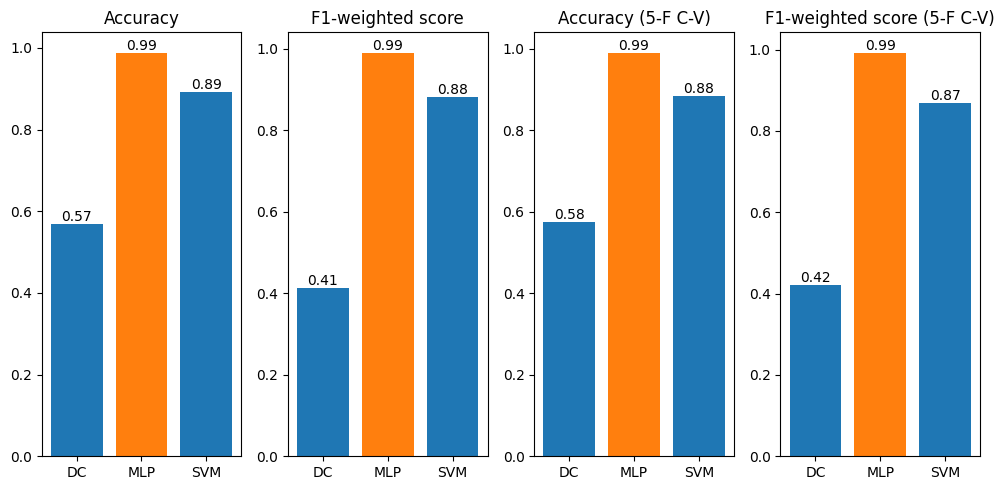

╭────────────────────────┬────────────┬─────────────────────┬──────────────────────────────────────┬───────────────────────────────────────────────╮
│ Classifier             │   Accuracy │   F1-weighted score │   Accuracy (5-Fold Cross-Validation) │   F1-weighted score (5-Fold Cross-Validation) │
├────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┤
│ Dummy Classifier       │       0.57 │                0.41 │                                 0.58 │                                          0.42 │
├────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┤
│ Multi-Layer Perceptron │       0.99 │                0.99 │                                 0.99 │                                          0.99 │
├────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼──────

In [8]:
color = 2 * ['tab:blue', 'tab:orange']

# bar plot accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.bar(range(len(ootb_accuracy)), list(ootb_accuracy.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy)), list(ootb_accuracy.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('Accuracy')

# bar plot f1 weighted score
plt.subplot(1, 4, 2)
plt.bar(range(len(ootb_f1)), list(ootb_f1.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1)), list(ootb_f1.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('F1-weighted score')

# bar plot cross validation accuracy
plt.subplot(1, 4, 3)
plt.bar(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_accuracy_cv)), list(ootb_accuracy_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('Accuracy (5-F C-V)')

# bar plot cross validation f1 weighted score
plt.subplot(1, 4, 4)
plt.bar(range(len(ootb_f1_cv)), list(ootb_f1_cv.values()), align='center', color=color)
plt.xticks(range(len(ootb_f1_cv)), list(ootb_f1_cv.keys()))
plt.bar_label(plt.gca().containers[0], fmt='%.2f')
plt.title('F1-weighted score (5-F C-V)')
plt.tight_layout()
plt.show()

# print table
headers = ["Classifier", "Accuracy", "F1-weighted score", "Accuracy (5-Fold Cross-Validation)", "F1-weighted score (5-Fold Cross-Validation)"]
data = [row for row in zip(names.values(), ootb_accuracy.values(), ootb_f1.values(), ootb_accuracy_cv.values(), ootb_f1_cv.values())]
print(tabulate(data, headers=headers, tablefmt='rounded_grid', floatfmt=".2f"))

When compared to the baseline, the Dummy Classifier, both the MLP and SVM classifiers perform a lot better. They easily beat the DC in all metrics with or without 5-Fold Cross-Validation.

The MLP classifier is already, out of the box, performing very well, with an accuracy of 0.99 and an F1-weighted score of 0.99. This is because the MLP classifier can handle very large datasets and is very flexible, while its default parameters are already working great with this dataset.

The SVM classifier is performing well, with an accuracy of 0.89 and a F1-weighted score of 0.88. In this case, hyperparameter optimization is needed to improve the performance, as the default ones are not as good as they were on the MLP classifier.

In [11]:
# remove dummy classifier values from dictionaries as they are not needed for later analysis
names.pop('DC')
ootb_accuracy.pop('DC')
ootb_f1.pop('DC')
ootb_accuracy_cv.pop('DC')
ootb_f1_cv.pop('DC')

### Optimization

#### Initializations and Feature Variance

In [13]:
# default transformers initialization
selector = VarianceThreshold()
standard = StandardScaler()
min_max = MinMaxScaler()
ros = RandomOverSampler()
rus = RandomUnderSampler()
pca = PCA()

# dictionaries to store results
optimized_accuracy_acc = {}
optimized_accuracy_f1 = {}
optimized_f1_acc = {}
optimized_f1_f1 = {}
train_time_acc = {}
train_time_f1 = {}
test_time_acc = {}
test_time_f1 = {}

In [14]:
# check variance to select threshold values
train_variance = X_train.var(axis=0)
print(f'- Train data feature variance: \n {train_variance}')
print(f'--------------------------------------------------------------------------------')
print(f'- Minimum, maximum, mean and median variance:')
print(f'{np.min(train_variance)}, {np.max(train_variance)}, {np.mean(train_variance)}, {np.median(train_variance)}')

- Train data feature variance: 
 [4.77393864e+05 3.30134068e-01 1.80834320e+02 5.01183129e+00
 2.69804374e+09 1.91963315e+07 0.00000000e+00 1.16734800e-02
 0.00000000e+00 4.68481082e-01 1.01204331e-04 1.25686658e-01
 7.40994925e-03 1.01204331e-04 0.00000000e+00 3.12015825e-02
 1.29531606e-02 4.04766100e-04 9.10429199e-04 9.60613905e-04
 4.54517666e+04 6.04042762e+04 1.40997808e-01 1.41232275e-01
 5.34894062e-02 5.36199431e-02 1.47663296e-01 6.39483352e-03
 2.03451825e-02 4.10925820e+03 1.10582354e+04 1.65478213e-01
 1.12909044e-02 2.30529068e-01 1.65516882e-03 1.40942131e-01
 1.41190014e-01 5.27810645e-02 5.28178314e-02]
--------------------------------------------------------------------------------
- Minimum, maximum, mean and median variance:
0.0, 2698043741.6702886, 69688171.25133218, 0.05361994314771506


#### Multi-Layer Perceptron

In [15]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('mlp', MLP)], memory='tmp')
threshold_acc = [0, 0.05, 0.1, 0.2, 0.5, 1]
hidden_layer_sizes = [(10,), (30,), (50,), (70,), (90,)]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [100, 200, 300, 400, 500]

estimator_acc = HalvingRandomSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, mlp__activation = activation, mlp__solver = solver, mlp__alpha = alpha, mlp__learning_rate = learning_rate, mlp__max_iter = max_iter, mlp__hidden_layer_sizes = hidden_layer_sizes), cv=5, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, activation: {results.iloc[i, 1]['mlp__activation']}, solver: {results.iloc[i, 1]['mlp__solver']}, alpha: {results.iloc[i, 1]['mlp__alpha']}, learning_rate: {results.iloc[i, 1]['mlp__learning_rate']}, max_iter: {results.iloc[i, 1]['mlp__max_iter']}, hidden_layer_sizes: {results.iloc[i, 1]['mlp__hidden_layer_sizes']}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network

accuracy: 0.9975, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.001, learning_rate: invscaling, max_iter: 300, hidden_layer_sizes: (30,)
accuracy: 0.9974, threshold: 0, activation: relu, solver: adam, alpha: 0.01, learning_rate: invscaling, max_iter: 400, hidden_layer_sizes: (70,)
accuracy: 0.9970, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.001, learning_rate: invscaling, max_iter: 300, hidden_layer_sizes: (30,)
accuracy: 0.9970, threshold: 0, activation: relu, solver: adam, alpha: 0.01, learning_rate: invscaling, max_iter: 400, hidden_layer_sizes: (70,)
accuracy: 0.9968, threshold: 0, activation: tanh, solver: lbfgs, alpha: 0.0001, learning_rate: invscaling, max_iter: 200, hidden_layer_sizes: (50,)
accuracy: 0.9965, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.01, learning_rate: adaptive, max_iter: 100, hidden_layer_sizes: (70,)
accuracy: 0.9946, threshold: 0, activation: logistic, solver: adam, alpha: 0.1, learning_rate: adaptive, max_iter: 200, hidd

In [16]:
# initialize pipeline and grid search for f1-weighted score
pipe_f1 = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('mlp', MLP)], memory='tmp')
threshold_f1 = [0, 0.03, 0.05, 0.1, 0.2, 0.5, 1]
hidden_layer_sizes = [(10,), (30,), (50,), (60), (70,), (90,)]
activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']
alpha = [0.0001, 0.001, 0.01, 0.1]
learning_rate = ['constant', 'invscaling', 'adaptive']
max_iter = [200, 300, 350, 400, 450]

estimator_f1 = HalvingRandomSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, mlp__activation = activation, mlp__solver = solver, mlp__alpha = alpha, mlp__learning_rate = learning_rate, mlp__max_iter = max_iter, mlp__hidden_layer_sizes = hidden_layer_sizes), cv=5, scoring='f1_weighted', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, activation: {results.iloc[i, 1]['mlp__activation']}, solver: {results.iloc[i, 1]['mlp__solver']}, alpha: {results.iloc[i, 1]['mlp__alpha']}, learning_rate: {results.iloc[i, 1]['mlp__learning_rate']}, max_iter: {results.iloc[i, 1]['mlp__max_iter']}, hidden_layer_sizes: {results.iloc[i, 1]['mlp__hidden_layer_sizes']}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network

f1: 0.9977, threshold: 0, activation: tanh, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 200, hidden_layer_sizes: (50,)
f1: 0.9972, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.1, learning_rate: adaptive, max_iter: 350, hidden_layer_sizes: (10,)
f1: 0.9949, threshold: 0, activation: tanh, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 200, hidden_layer_sizes: (50,)
f1: 0.9945, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.0001, learning_rate: adaptive, max_iter: 300, hidden_layer_sizes: (70,)
f1: 0.9943, threshold: 0, activation: relu, solver: adam, alpha: 0.0001, learning_rate: invscaling, max_iter: 400, hidden_layer_sizes: (50,)
f1: 0.9940, threshold: 0, activation: relu, solver: lbfgs, alpha: 0.001, learning_rate: constant, max_iter: 400, hidden_layer_sizes: 60
f1: 0.9940, threshold: 0, activation: tanh, solver: adam, alpha: 0.001, learning_rate: adaptive, max_iter: 200, hidden_layer_sizes: (50,)
f1: 0.9939, threshold: 0, activa

In [17]:
zipped = zip(["Accuracy", "F1-weighted score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['MLP'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['MLP'] = end - start
    
    # get accuracy and f1 weighted score on test data
    optimized_accuracy['MLP'] = accuracy_score(y_test, y_preds)
    optimized_f1['MLP'] = f1_score(y_test, y_preds, average='weighted')

    # print best estimator
    print(f"- Multi-Layer Perceptron model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (5-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}") 

    # print accuracy and f1 weighted score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['MLP'], 2)}")
    print(f"F1-weighted score: {np.format_float_positional(optimized_f1['MLP'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['MLP'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['MLP'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# store the best of the two mlp ones for the confusion matrix
best_estimator = estimator_acc.best_estimator_

- Multi-Layer Perceptron model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('mlp', MLPClassifier(alpha=0.001, hidden_layer_sizes=(30,), learning_rate='invscaling',
              max_iter=300, solver='lbfgs'))]
Accuracy (5-Fold Cross-Validation): 1.
Accuracy: 1.
F1-weighted score: 1.
Time to fit: 69.72453 sec
Time to predict: 0.03397 sec
--------------------------------------------------------------------------------
- Multi-Layer Perceptron model selection based on F1-weighted score
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('scaler', StandardScaler()), ('sampler', RandomOverSampler()), ('mlp', MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(50,),
              learning_rate='adaptive'))]
F1-weighted score (5-Fold Cross-Validation): 1.
Accuracy: 1.
F1-weighted score: 1.
Time to fit: 9.33828 sec
Time to predict: 0.03714 sec


In [14]:
# optuna study for mlp
def objective(trial):
    selector = VarianceThreshold(threshold=trial.suggest_uniform("threshold", 0, 1))
    standard = StandardScaler()
    ros = RandomOverSampler(random_state=42)
    MLP = MLPClassifier(random_state=42, activation=trial.suggest_categorical("activation", ['identity', 'logistic', 'tanh', 'relu']), solver=trial.suggest_categorical("solver", ['lbfgs', 'sgd', 'adam']), alpha=trial.suggest_categorical("alpha", [0.0001, 0.001, 0.01, 0.1]), learning_rate=trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive']), max_iter=trial.suggest_int("max_iter", 200 , 500, 20), hidden_layer_sizes=trial.suggest_categorical("hidden_layer_sizes", [(10,), (20,), (30,), (40,), (50,), (60), (70,), (80,), (90,)]))
    pipe = Pipeline(steps=[('selector', selector), ('scaler', standard), ('sampler', ros), ('mlp', MLP)], memory='tmp')
    return cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=5, scoring="accuracy").mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best Accuracy:", np.round(study.best_value, 3), '%')
print("Best Params:", study.best_params)

[I 2022-12-06 18:48:18,750] A new study created in memory with name: no-name-730eb1e6-2922-434c-a334-513c0ac0575b
/tmp/ipykernel_7266/1757499522.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  selector = VarianceThreshold(threshold=trial.suggest_uniform("threshold", 0, 1))
/home/codespace/.python/current/lib/python3.10/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10,) which is of type tuple.
  warnings.warn(message)
/home/codespace/.python/current/lib/python3.10/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (20,) which is of type tuple.
  warn

Best Accuracy: 0.993 %
Best Params: {'threshold': 0.48547221342319813, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 380, 'hidden_layer_sizes': (30,)}


For the MLP classifier, as noted before, the accuracy and the F1-weighted score are, out of the box, almost perfect. We started optimizing the MLP classifier for both metrics using the halving random search which is faster than the regular grid search. We started with a bigger search space for variance threshold, max_iter and alpha and worked in narrowing it down, while trying to focus on a more specific range of values. We also figured out that the estimator performed better without the use of PCA, so we removed it from the pipeline.

Without the need for much work and tuning, we achieved a perfect score (rounded up to two decimal places) for both metrics, with an accuracy of 1.0 and an F1-weighted score of 1.0. The Optuna study was mainly used for demonstration purposes since it was required for the assignment. The metric chosen for the Optuna study was accuracy. We believe that we would have achieved the same results, had we started with the Optuna library first. Our plan was to narrow down the search space first, so we could have a better and possibly uniform space for Optuna to search, but we reached perfect scores just from our grid search, therefore we didn't need to work much with Optuna.

The same applies for the SVM optimization procedure, as will be shown below.

#### Support Vector Machine

In [18]:
# initialize pipeline and grid search for accuracy
pipe_acc = Pipeline([('selector', selector), ('standard', standard), ('ros', ros), ('SVM', SVM)], memory='tmp')
threshold_acc = [0, 0.05, 0.1, 0.2, 0.5, 1]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.1, 1, 10, 100]
tol = [0.0001, 0.001, 0.01, 0.1]
gamma = ['scale', 'auto']

estimator_acc = HalvingGridSearchCV(pipe_acc, dict(selector__threshold=threshold_acc, SVM__kernel = kernel, SVM__C = C, SVM__tol = tol, SVM__gamma = gamma), cv=5, scoring='accuracy', n_jobs=-1)
estimator_acc.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_acc.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"accuracy: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, C: {results.iloc[i, 1]['SVM__C']}, tol: {results.iloc[i, 1]['SVM__tol']}, gamma: {results.iloc[i, 1]['SVM__gamma']}, kernel: {results.iloc[i, 1]['SVM__kernel']}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  

accuracy: 0.9979, threshold: 0, C: 100, tol: 0.01, gamma: scale, kernel: rbf
accuracy: 0.9979, threshold: 0, C: 100, tol: 0.001, gamma: scale, kernel: rbf
accuracy: 0.9979, threshold: 0, C: 100, tol: 0.1, gamma: scale, kernel: rbf
accuracy: 0.9979, threshold: 0, C: 100, tol: 0.0001, gamma: scale, kernel: rbf
accuracy: 0.9977, threshold: 0, C: 100, tol: 0.01, gamma: auto, kernel: rbf
accuracy: 0.9976, threshold: 0, C: 100, tol: 0.001, gamma: auto, kernel: rbf
accuracy: 0.9976, threshold: 0, C: 10, tol: 0.001, gamma: auto, kernel: rbf
accuracy: 0.9976, threshold: 0, C: 100, tol: 0.0001, gamma: auto, kernel: rbf
accuracy: 0.9976, threshold: 0, C: 10, tol: 0.0001, gamma: auto, kernel: rbf


In [19]:
# initialize pipeline and grid search for f1-weighted score
pipe_f1 = Pipeline([('selector', selector), ('standard', standard), ('ros', ros), ('SVM', SVM)], memory='tmp')
threshold_f1 = [0, 0.03, 0.05, 0.1, 0.2, 0.5, 1]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.1, 1, 10, 100]
tol = [0.0001, 0.001, 0.01, 0.1]
gamma = ['scale', 'auto']

estimator_f1 = HalvingGridSearchCV(pipe_f1, dict(selector__threshold=threshold_f1, SVM__kernel = kernel, SVM__C = C, SVM__tol = tol, SVM__gamma = gamma), cv=5, scoring='f1_weighted', n_jobs=-1)
estimator_f1.fit(X_train, y_train)

# print top 9 results
results = pd.DataFrame(estimator_f1.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
results = results[['mean_test_score', 'params']]

for i in range(9):
    print(f"f1: {np.format_float_positional(results.iloc[i, 0], 4)}, threshold: {results.iloc[i, 1]['selector__threshold']}, C: {results.iloc[i, 1]['SVM__C']}, tol: {results.iloc[i, 1]['SVM__tol']}, gamma: {results.iloc[i, 1]['SVM__gamma']}, kernel: {results.iloc[i, 1]['SVM__kernel']}")

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  

f1: 1., threshold: 0.05, C: 100, tol: 0.01, gamma: auto, kernel: linear
f1: 1., threshold: 0.05, C: 1, tol: 0.1, gamma: scale, kernel: linear
f1: 1., threshold: 0, C: 100, tol: 0.0001, gamma: scale, kernel: rbf
f1: 1., threshold: 0.03, C: 100, tol: 0.0001, gamma: scale, kernel: rbf
f1: 1., threshold: 0.05, C: 100, tol: 0.0001, gamma: scale, kernel: rbf
f1: 1., threshold: 0, C: 100, tol: 0.001, gamma: scale, kernel: rbf
f1: 1., threshold: 0.03, C: 100, tol: 0.001, gamma: scale, kernel: rbf
f1: 1., threshold: 0.05, C: 100, tol: 0.001, gamma: scale, kernel: rbf
f1: 1., threshold: 0, C: 100, tol: 0.01, gamma: scale, kernel: rbf


In [20]:
zipped = zip(["Accuracy", "F1-weighted score"],
             [estimator_acc, estimator_f1],
             [train_time_acc, train_time_f1],
             [test_time_acc, test_time_f1],
             [optimized_accuracy_acc, optimized_accuracy_f1],
             [optimized_f1_acc, optimized_f1_f1])

for scoring, estimator, train_time, test_time, optimized_accuracy, optimized_f1 in zipped:
    # get fit and predict times on test data
    start = time.time()
    estimator.best_estimator_.fit(X_train, y_train)
    end = time.time()
    train_time['SVM'] = end - start

    start = time.time()
    y_preds = estimator.best_estimator_.predict(X_test)
    end = time.time()
    test_time['SVM'] = end - start
    
    # get accuracy and f1 weighted score on test data
    optimized_accuracy['SVM'] = accuracy_score(y_test, y_preds)
    optimized_f1['SVM'] = f1_score(y_test, y_preds, average='weighted')

    # print best estimator
    print(f"- Support Vector Machine model selection based on {scoring}")
    print(f"Best estimator: {estimator.best_estimator_.steps}")
    print(f"{scoring} (5-Fold Cross-Validation): {np.format_float_positional(estimator.best_score_, 2)}")

    # print accuracy and f1 score
    print(f"Accuracy: {np.format_float_positional(optimized_accuracy['SVM'], 2)}")
    print(f"F1-weighted score: {np.format_float_positional(optimized_f1['SVM'], 2)}")

    # print fit and predict times
    print(f"Time to fit: {np.format_float_positional(train_time['SVM'], 5)} sec")
    print(f"Time to predict: {np.format_float_positional(test_time['SVM'], 5)} sec")

    if estimator != estimator_f1:
        print(f"--------------------------------------------------------------------------------")

# store the best of the two sv ones for the confusion matrix
best_estimator_2 = estimator_acc.best_estimator_

- Support Vector Machine model selection based on Accuracy
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=100, tol=0.0001))]
Accuracy (5-Fold Cross-Validation): 1.
Accuracy: 1.
F1-weighted score: 1.
Time to fit: 2.94667 sec
Time to predict: 1.78703 sec
--------------------------------------------------------------------------------
- Support Vector Machine model selection based on F1-weighted score
Best estimator: [('selector', VarianceThreshold(threshold=0)), ('standard', StandardScaler()), ('ros', RandomOverSampler()), ('SVM', SVC(C=10, gamma='auto', kernel='linear', tol=0.01))]
F1-weighted score (5-Fold Cross-Validation): 1.
Accuracy: 1.
F1-weighted score: 1.
Time to fit: 2.39676 sec
Time to predict: 0.41631 sec


In [19]:
# optuna study for svm
def objective(trial):
    selector = VarianceThreshold(threshold=trial.suggest_uniform('threshold', 0, 1))
    standard = StandardScaler()
    ros = RandomOverSampler()
    SVM = SVC(C=trial.suggest_categorical('C', [0.1, 1, 10, 100]), kernel=trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']), tol=trial.suggest_categorical('tol', [0.0001, 0.001, 0.01, 0.1]), gamma=trial.suggest_categorical('gamma', ['scale', 'auto']), random_state=42)
    pipe = Pipeline([('selector', selector), ('standard', standard), ('ros', ros), ('SVM', SVM)], memory='tmp')
    return cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=5, scoring='f1_weighted').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best F1-weighted score: {np.format_float_positional(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")

[I 2022-12-06 19:10:07,449] A new study created in memory with name: no-name-c80872fd-00a3-4ab5-9f78-42e61970688a
/tmp/ipykernel_7266/1591858477.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  selector = VarianceThreshold(threshold=trial.suggest_uniform('threshold', 0, 1))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[I 2022-12-06 19:11:01,000] Trial 0 finished with value: 0.9758730544517787 and parameters: {'threshold': 0.9972964617077807, 'C': 0.1, 'kernel': 'linear', 'tol': 0.001, 'gamma': 'scale'}. Best is trial 0 with value: 0.9758730544517787.
/tmp/ipykernel_7266/1591858477.py:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature

Best F1-weighted score: 0.99
Best parameters: {'threshold': 0.9673560360367283, 'C': 10, 'kernel': 'poly', 'tol': 0.0001, 'gamma': 'auto'}


For the SVM classifier, the out of the box scores could be improved through hyperparameter tuning. We started optimizing the SVM classifier for both accuracy and F1-weighted score. In this case, halving grid search was quite faster than the one we tried using on the MLP optimization, so there wasn't any need to use random search. We started with a bigger search space for variance threshold, C and gammaand worked in narrowing it down, while trying to focus on a more specific range of values. We also figured out that the estimator performed better without the use of PCA, so we removed it from the pipeline.

Once again without much work and tuning, we achieved a perfect score (rounded up to two decimal places) for both metrics, with an accuracy of 1.0 and an F1-weighted score of 1.0. This time the F1-weighted score metric was chosen for the Optuna study. We believe that we would have achieved the same results, had we started with the Optuna library first. Our plan was to narrow down the search space first, so we could have a better and possibly uniform space for Optuna to search, but we reached perfect scores just from our grid search, therefore we didn't need to work much with Optuna.

## Results and Conclusion

### Tables

In [21]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_acc = {}
diff_f1_acc = {}

for model in optimized_accuracy_acc:
    diff_acc_acc[model] = (optimized_accuracy_acc[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_acc[model] = (optimized_f1_acc[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_acc = ["Best Classifier by Accuracy", "Accuracy", "F1-weighted score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1-weighted score (%)", "Train time (sec)", "Test time (sec)"]
data_acc = [row for row in zip(names.values(), optimized_accuracy_acc.values(), optimized_f1_acc.values(), diff_acc_acc.values(), diff_f1_acc.values(), train_time_acc.values(), test_time_acc.values())]
print(tabulate(data_acc, headers=headers_acc, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭───────────────────────────────┬────────────┬─────────────────────┬──────────────────────────────────────┬───────────────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by Accuracy   │   Accuracy │   F1-weighted score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1-weighted score (%) │   Train time (sec) │   Test time (sec) │
├───────────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multi-Layer Perceptron        │       1.00 │                1.00 │                                 1.00 │                                          0.81 │           69.72453 │           0.03397 │
├───────────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Support Vecto

In [22]:
# dictionaries to hold the percentage differences between the optimized and default models
diff_acc_f1 = {}
diff_f1_f1 = {}

for model in optimized_accuracy_f1:
    diff_acc_f1[model] = (optimized_accuracy_f1[model] - ootb_accuracy[model]) / ootb_accuracy[model] * 100
    diff_f1_f1[model] = (optimized_f1_f1[model] - ootb_f1[model]) / ootb_f1[model] * 100

# print the table
headers_f1= ["Best Classifier by F1-weighted score", "Accuracy", "F1-weighted score", "Optimized vs OOTB for Accuracy (%)", "Optimized vs OOTB for F1-weighted score (%)", "Train time (sec)", "Test time (sec)"]
data_f1 = [row for row in zip(names.values(), optimized_accuracy_f1.values(), optimized_f1_f1.values(), diff_acc_f1.values(), diff_f1_f1.values(), train_time_f1.values(), test_time_f1.values())]
print(tabulate(data_f1, headers=headers_f1, tablefmt='rounded_grid', floatfmt=("", ".2f", ".2f", ".2f", ".2f", ".5f", ".5f")))

╭────────────────────────────────────────┬────────────┬─────────────────────┬──────────────────────────────────────┬───────────────────────────────────────────────┬────────────────────┬───────────────────╮
│ Best Classifier by F1-weighted score   │   Accuracy │   F1-weighted score │   Optimized vs OOTB for Accuracy (%) │   Optimized vs OOTB for F1-weighted score (%) │   Train time (sec) │   Test time (sec) │
├────────────────────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┼────────────────────┼───────────────────┤
│ Multi-Layer Perceptron                 │       1.00 │                1.00 │                                 0.91 │                                          0.74 │            9.33828 │           0.03714 │
├────────────────────────────────────────┼────────────┼─────────────────────┼──────────────────────────────────────┼───────────────────────────────────────────────┼────────────

On the above tables, we can see that after the optimization both classifiers reach an accuracy of 1.00 and an F1-weighted score of 1.00. These numbers are rounded up to 2 decimal places, therefore it is possible that the actual values are slightly different, and not all samples are classified correctly. 

The MLP classifier was already perfoming close to perfect out of the box, so the optimization didn't change much (around 1% in both metrics). The SVM classifier was already performing well, but the optimization improved it even more. (ardound 11% on accuracy and 13% on F1-weighted score).

As far as train and test times are concerned, the SVM classifier is a lot faster than the MLP classifier on training by a huge margin, while on testing the MLP classifier is faster by a big margin as well.

### Bar Charts

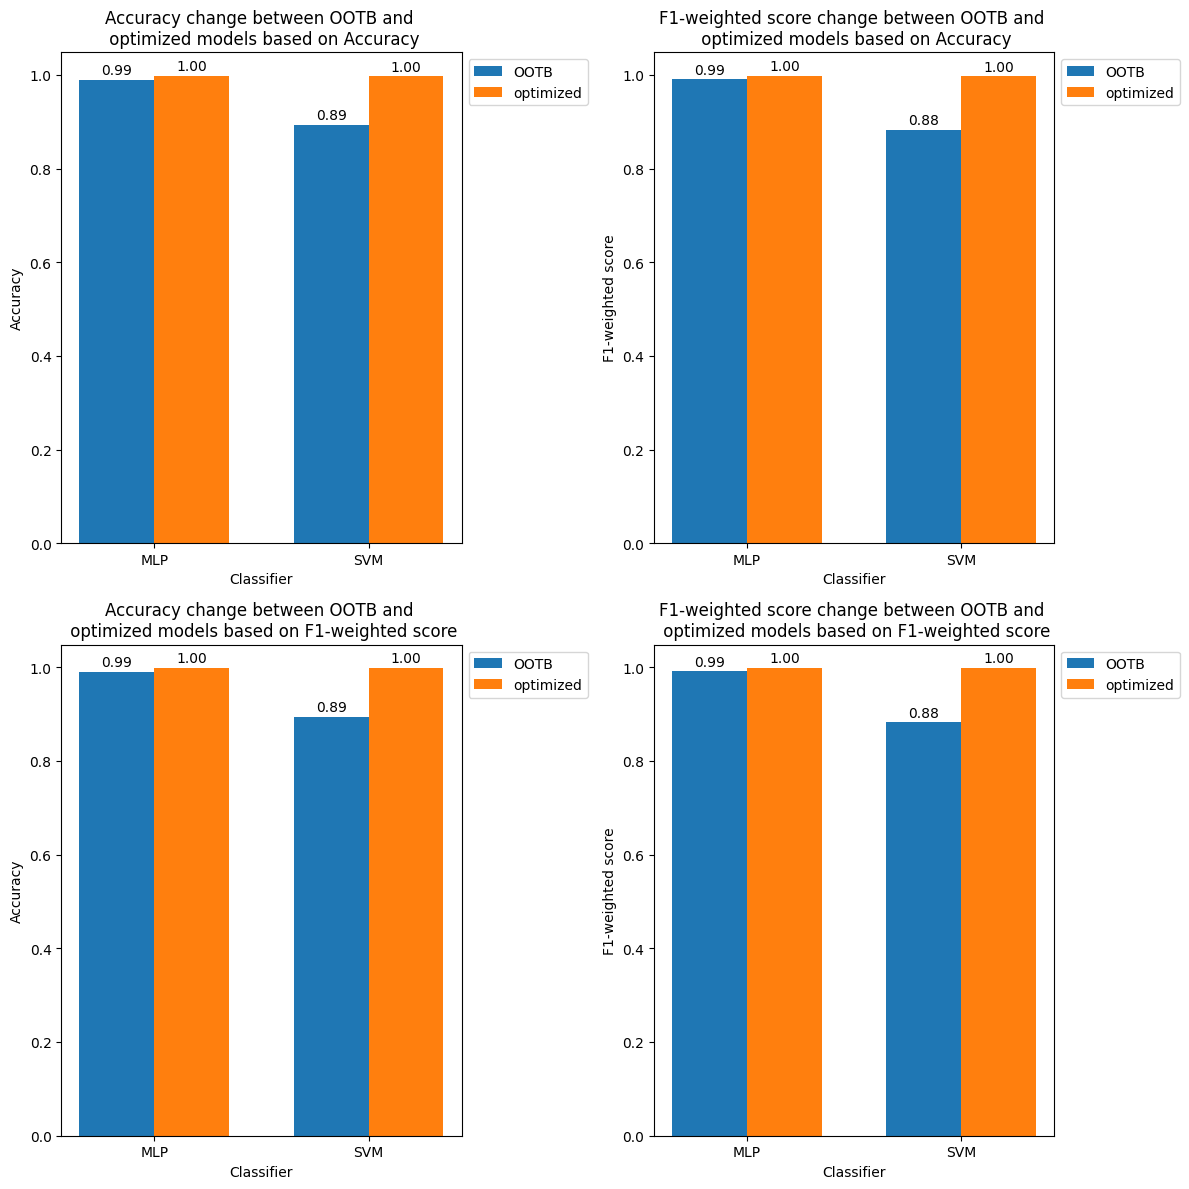

In [23]:
# print bar charts for the changes in accuracy and f1 score based on accuracy and f1 score
zipped = zip([(0, 0), (0, 1), (1, 0), (1, 1)], 
             [ootb_accuracy, ootb_f1, ootb_accuracy, ootb_f1],
             [optimized_accuracy_acc, optimized_f1_acc, optimized_accuracy_f1, optimized_f1_f1],
             ["Accuracy", "F1-weighted score", "Accuracy", "F1-weighted score"],
             ["Accuracy", "Accuracy", "F1-weighted score", "F1-weighted score"])

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
x = np.arange(len(names))
width = 0.35

for index, ootb, optimized, scoring, base in zipped:
    rects1 = ax[index].bar(x - width/2, ootb.values(), width, label='OOTB')
    rects2 = ax[index].bar(x + width/2, optimized.values(), width, label='optimized')
    ax[index].set_ylabel(scoring)
    ax[index].set_xlabel("Classifier")
    ax[index].set_title(f"{scoring} change between OOTB and \n optimized models based on {base}")
    ax[index].set_xticks(x, names.keys())
    ax[index].legend(bbox_to_anchor=(1, 1))
    ax[index].bar_label(rects1, padding=2, fmt='%.2f')
    ax[index].bar_label(rects2, padding=2, fmt='%.2f')

fig.tight_layout()
plt.show()

As already noted before, here we can see that the MLP classifier was performing almost perfect out of the box, and didn't have much space for improvement through optimization. The SVM classifier, despite performing well out of the box, was able to show around 11%-13% increase in both metrics, through optimization.

### Confusion Matrices

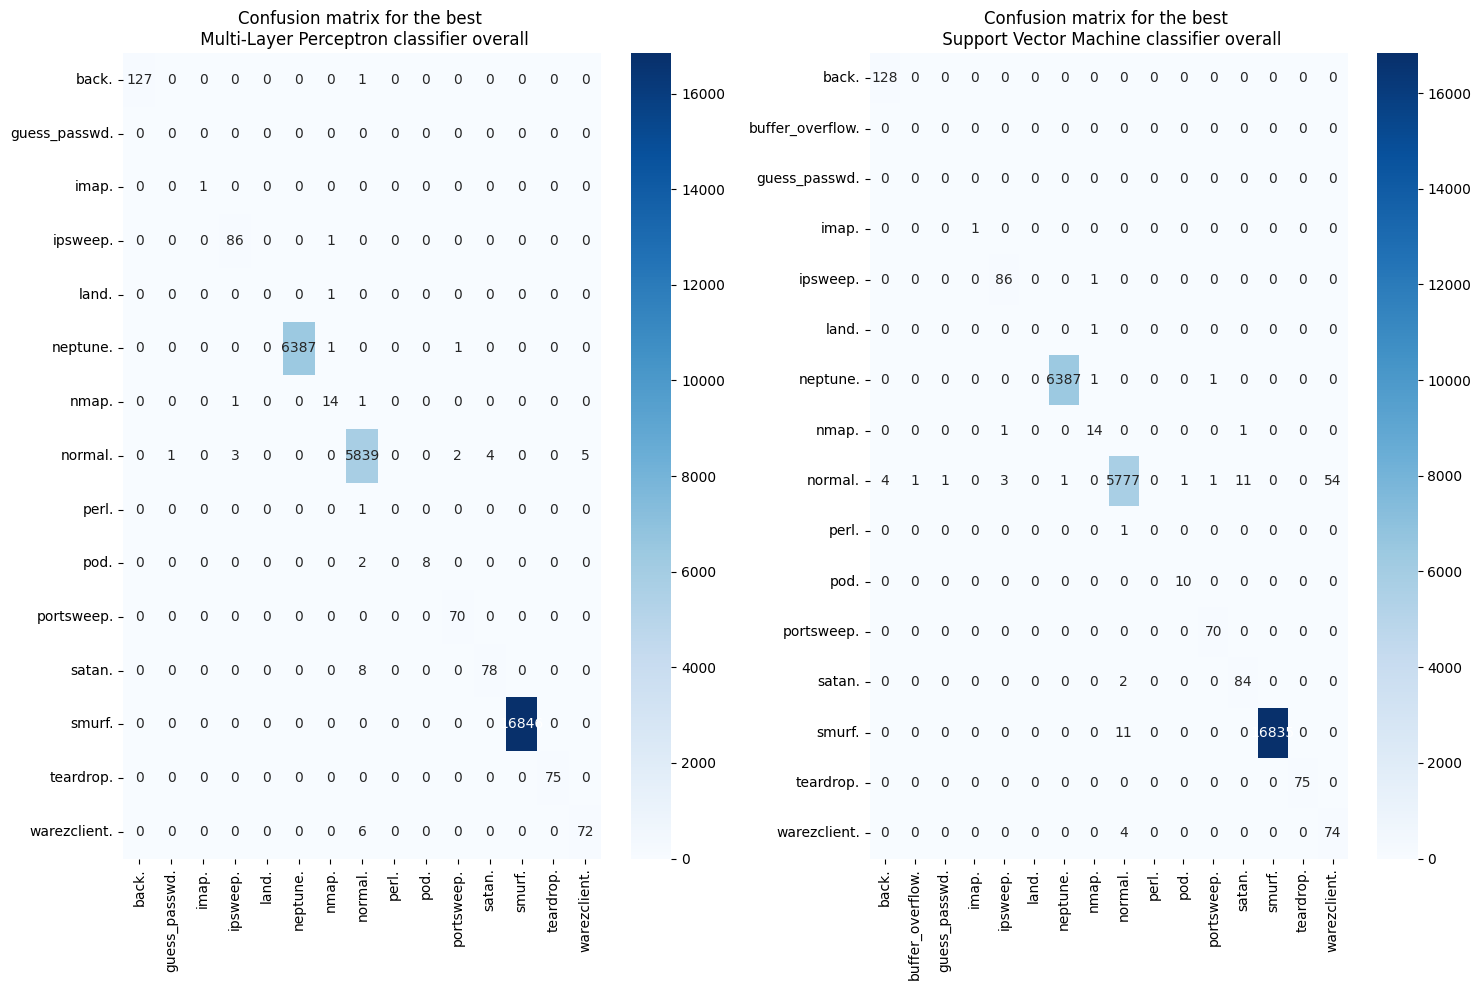

In [24]:
# print the confusion matrix for the best and worst model based on acurracy
zipped = zip([0, 1],
             [best_estimator, best_estimator_2],
             ['MLP', 'SVM'])

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

for index, estimator, classifier in zipped:
    y_pred = estimator.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    class_names = np.sort(np.unique(np.concatenate((np.unique(y_test), np.unique(y_pred)))))
    labels = np.asarray(["{0:0.0f}".format(value) for value in cf_matrix.flatten()]).reshape(cf_matrix.shape[0],cf_matrix.shape[1])
    sns.heatmap(cf_matrix, annot=labels, fmt="", ax=ax[index], cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax[index].set_title(f"Confusion matrix for the best \n {names[classifier]} classifier overall")

fig.tight_layout()
plt.show()

On these confusion matrices, we can see that both best classifiers (the first one is the best MLP, the other is the best SVM) perform almost perfect. There are only a few samples missclassified and they don't seem to be following a specific pattern as they are scattered around different classes. On the main diagonal, we can see the correctly classified samples and the darker blue colors for the most frequent classes.

### Conclusion

For this dataset, it was possible for us to optimize both the MLP and SVM classifiers and have them reach an almost perfect score on both the metrics we selected, accuracy and F1-weighted score. Their performance is similar in those metrics, however there is a difference in the train and test times. If train time is a concern, the SVM classifier is the best choice, as it is a lot faster than the MLP classifier. If test time is a concern, the MLP classifier is the best choice, as it is a lot faster than the SVM classifier.

All in all, there is no obvious choice for this dataset, as performance is similar and these two classifier both win one category in respect to times. However, having the ability to quickly classify a future attack is more important than the time the model will take to train, therefore, our final choice is the MLP classifier, which has a faster test time than the SVM classifier.